This is a model of a 2-layer neural network
Steps:
1- Load the dataset

2 - Initialize parameters (weights and bias)

3 - forward propagation

4 - cost function

5 - backward propagation

6 - update parameters

7 - run the model

8 - predict


In [16]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

# 1 - load the dataset
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Quick review:
    - Weights: represent the strength of connections between units
    - Bias : allows you to move the curve to fit the prediction with the data better.

In [17]:
#2 -  Initialize parameters
#We initialize bias as zeros and weights with random numbers

def initialize_parameters(n_x, n_h, n_y):

    np.random.seed(1)

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
 
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

We can separate the forward propagation in linear and activation modules.

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

where $A^{[0]} = X$. 

Nowadays we can use sigmoid(old) or ReLu, to give us the activation vector






In [18]:
# 3 -  Forward propagation

def linear_forward(A, W, b):
    Z = np.dot(W,A) + b
    cache = (A, W, b)

    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
      
    
    elif activation == "relu":
       
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
       
    cache = (linear_cache, activation_cache)

    return A, cache
    


Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$


In [19]:
#4 - Cost function
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    return cost
    


For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

$(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.



$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


In [20]:
#5 - backpropagation
def linear_backward(dZ, cache):
    
    #Implement the linear portion of backward propagation for a single layer (layer l)

    A_prev, W, b = cache
    m = A_prev.shape[1]

    
    dW = (1. / m) * np.dot(dZ, cache[0].T) 
    db = (1. / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(cache[1].T, dZ)

    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
       
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
  
    elif activation == "sigmoid":
       
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

        
    return dA_prev, dW, db

Update parameters using gradient descent on every $W^{[l]}$ and $b^{[l]}$ for $l = 1, 2, ..., L$. 

In [24]:
#6 - update parameters
def update_parameters(parameters, grads, learning_rate):
    parameters = parameters.copy()
    L = len(parameters) // 2 # number of layers in the neural network

    
    for l in range(L):
      
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]

    return parameters
    

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.515830477276473
Cost after iteration 600: 0.47549013139433266
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.400797753620389
Cost after iteration 900: 0.35807050113237987
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.30527536361962637
Cost after iteration 1200: 0.27491377282130186
Cost after iteration 1300: 0.2468176821061485
Cost after iteration 1400: 0.19850735037466086
Cost after iteration 1500: 0.17448318112556657
Cost after iteration 1600: 0.17080762978096237
Cost after iteration 1700: 0.11306524562164721
Cost after iteration 1800: 0.09629426845937147
Cost after iteration 1900: 0.08342617959726858
Cost after iteration 2000: 0.07439078704319078
Cost after iteration 2100: 0.066307481

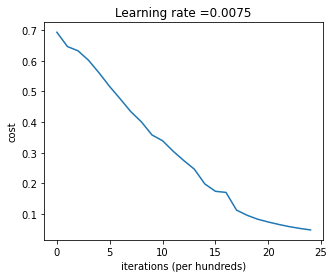

In [25]:
#7 - run the model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
 
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
   
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
      
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
        
        # YOUR CODE ENDS HERE
        
        # Compute cost
       
        cost = compute_cost(A2, Y)
        
      
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        #(≈ 2 lines of code)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
       
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
        
        
        # YOUR CODE ENDS HERE
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads["dW1"] = dW1
        grads["db1"] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
      
        parameters = update_parameters(parameters, grads, learning_rate)
        
        
        # YOUR CODE ENDS HERE

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)
plot_costs(costs, learning_rate)

In [26]:
#train accuracy
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [27]:
#test accuracy
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


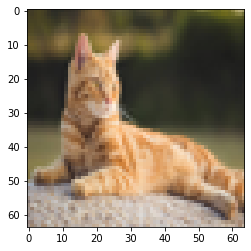

In [31]:
#8 - predict
my_image = "my_image2.jpg" 
my_label_y = [1] 

fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)


print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")